In [2]:
import pandas as pd
import random
import numpy as np
import json
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, LSTM, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model

#pip install keras-tuner
#pip install stop-words
import kerastuner
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import BayesianOptimization 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tikzplotlib


from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset
from azureml.core import Workspace

tf.compat.v1.set_random_seed(666)

Using TensorFlow backend.


In [3]:
# Methods 

def train_val_test_split(X,y, test_size , val_size , random_state):
    # split the data into training, validation and test set
    # test size determines the partition one needs to make from X_int
    
    val_s = val_size/(1-test_size)
    
    X_int, X_test, y_int, y_test = train_test_split(X, y , stratify=y,
                                                    test_size=test_size,
                                                    random_state=random_state)
    
    X_train, X_val, y_train, y_val = train_test_split(X_int, y_int, stratify=y_int,
                                                     test_size=val_s,
                                                     random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test 


def keras_vector(X):
    # reshapes the vector to keras compatible shape (len, len_feat, 1)
    return X.reshape(X.shape[0], X.shape[1], 1)

def history_graph_v(history, figure_name):
    figure(figsize=(8, 6), dpi=80)
    plt.plot(history.history['F1_score'])
    plt.plot(history.history['val_F1_score'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('model accuracy')
    plt.ylabel('F1 Score / Loss')
    plt.xlabel('Epoch')
    plt.legend(['train F1', 'val F1','train loss', 'val loss'], loc='upper left')
    tikzplotlib.save(figure_name+".tex")
    

def history_graph_t(history, figure_name):
    figure(figsize=(8, 6), dpi=80)
    plt.plot(history.history['F1_score'])
    plt.plot(history.history['val_F1_score'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('model accuracy')
    plt.ylabel('F1 Score / Loss')
    plt.xlabel('Epoch')
    plt.legend(['train F1', 'test F1','train loss', 'test loss'], loc='upper left')
    tikzplotlib.save(figure_name+".tex")

def F1_score(y_true, y_pred):

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
        all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (all_positives + K.epsilon())
        return recall

    def precision(y_true,y_pred):
        true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    recall = recall(y_true, y_pred)
    precision = precision(y_true,y_pred)

    return 2*((precision*recall)/(precision + recall + K.epsilon()))

def hp_search(X_train, X_val, y_train, y_val, project_name):
    
    def build_model(hp):
        cnn = Sequential()

        cnn.add(Conv1D(hp.Int('input_units',32,128,32),
                       hp.Choice('filter_size',
                                 values=[3,5],
                                 default=3),
                       input_shape=(67,1),
                       padding='causal',
                       activation=hp.Choice('input_activation',
                                            values = ['relu', 'tanh']
                                            )))
        
        cnn.add(MaxPooling1D(pool_size=(2), strides=(2)))

        for i in range(hp.Int('n_layers', 1,3)):
            
            cnn.add(Conv1D(hp.Int(f'con_{i}_units',32,128,32),
                           hp.Choice(f'con_{i}_filter_size',
                                     values=[3,5],
                                     default=3),
                           padding='valid',
                           activation= hp.Choice(f'con_{i}_activation',
                                                 values = ['relu', 'tanh'],
                                                 default = 'relu')))
            
            cnn.add(Dropout(hp.Choice(f'con_{i}_drop_out',
                                      values=[0.1,0.2,0.3,0.4,0.5], default=0.1)))
            

        cnn.add(Flatten())
        
        cnn.add(Dense(hp.Int('dense_units',32,128,32)))
        
        
        cnn.add(Dense(1, activation='sigmoid'))
        
        
        
        cnn.compile(loss='binary_crossentropy',
                    optimizer= Adam(hp.Choice('learning_rate',
                                              values=[5e-4 ,1e-4, 5e-5,2e-5], default=2e-5)),
                    metrics = ['accuracy'])
                    #metrics = ['accuracy', F1_score, 'Recall']

        return cnn

    
    tuner = BayesianOptimization(build_model,
                    objective = kerastuner.Objective('val_F1_score', direction="max"),
                    max_trials =100 ,
                    metrics = [F1_score],
                    executions_per_trial = 2,
                                 project_name=project_name)
    tuner.search(x=X_train,
                 y=y_train,
                 validation_data=(X_val,y_val),
                 batch_size=32 ,
                 epochs=15, 
                 callbacks= [EarlyStopping('val_loss', patience=3)])
        
    return tuner

def best_model_params(tuner):
    return tuner.get_best_hyperparameters()[0].values


def best_model_builder(dict_best_hp):
    cnn = Sequential()
    cnn.add(Conv1D(dict_best_hp['input_units'],
                   dict_best_hp['filter_size'], 
                   padding='causal', 
                   input_shape=(67,1),
                   activation= dict_best_hp['input_activation']))
    cnn.add(MaxPooling1D(pool_size=(2), strides=(2)))
    
    for i in range(dict_best_hp['n_layers']):
                
            cnn.add(Conv1D(dict_best_hp[f'con_{i}_units'],
                           dict_best_hp[f'con_{i}_filter_size'],
                           padding='causal', 
                           activation=dict_best_hp[f'con_{i}_activation']))

            cnn.add(Dropout(dict_best_hp[f'con_{i}_drop_out']))
        
    
    cnn.add(Flatten())
    cnn.add(Dense(dict_best_hp['dense_units']))
        
    cnn.add(Dense(1, activation='sigmoid'))
    
    cnn.compile(loss='binary_crossentropy',
                optimizer=Adam(dict_best_hp['learning_rate']),
                metrics = ['accuracy', F1_score])
    
    return cnn

def evaluate_model(dict_best_hp, X_train, X_val, X_test, y_train, y_val , y_test, model_name):
    
    model= best_model_builder(dict_best_hp)
    X_tr = np.vstack((X_train, X_val))
    y_tr = np.hstack((y_train, y_val))
    
    history = model.fit(X_tr,y_tr, validation_data=(X_test,y_test),batch_size=32, epochs=25)
    
    #model.save(model_name)
    
    with open(model_name+'_dict.json', 'w') as f:
        json.dump(dict_best_hp, f)
    
    return history

def model_parameter_getter( file_name):
    with open(file_name) as f:
        dict_ = json.load(f)
    return dict_

best_params = model_parameter_getter('model_cnn_only_all_dict.json')

def final_model_builder(dict_best_hp, input_shape):
    cnn = Sequential()
    cnn.add(Conv1D(dict_best_hp['input_units'],
                   dict_best_hp['filter_size'], 
                   padding='causal', 
                   input_shape=input_shape,
                   activation= dict_best_hp['input_activation']))
    cnn.add(MaxPooling1D(pool_size=(2), strides=(2)))
    
    for i in range(dict_best_hp['n_layers']):
                
            cnn.add(Conv1D(dict_best_hp[f'con_{i}_units'],
                           dict_best_hp[f'con_{i}_filter_size'],
                           padding='causal', 
                           activation=dict_best_hp[f'con_{i}_activation']))

            cnn.add(Dropout(dict_best_hp[f'con_{i}_drop_out']))
        
    
    cnn.add(Flatten())
    cnn.add(Dense(dict_best_hp['dense_units']))
        
    cnn.add(Dense(1, activation='sigmoid'))
    
    cnn.compile(loss='binary_crossentropy',
                optimizer=Adam(dict_best_hp['learning_rate']),
                metrics = ['accuracy', F1_score])
    
    return cnn

# Balancing Strategy: Under-sampling 

In [4]:
# Load the downsampled data 

# get the configs for the Azure Workspace
ws = Workspace.from_config()
# initialize location of the data (blob)
datastore_name = 'mlthesisdatablob'
dataset_name='data.cleaned.raw'
#load the data of english examples
datastore = Datastore.get(ws, datastore_name)
datapath = datastore.path('data_all_lang_downsampling.csv')
dataset = Dataset.auto_read_files(datapath)

d = dataset.register(workspace=ws, name=dataset_name, exist_ok=True, update_if_exist=True)

dataset = Dataset.get(ws,dataset_name)
# create a dataframe
df = dataset.to_pandas_dataframe()

#Alternatively: Load data from csv in directory 
# import pandas as pd

# df_en = pd.read_csv('data_english.csv')

df.head()

# create a dataset for each language

df_en = df[df.lang_final=='en']
df_es = df[df.lang_final=='es']
df_it = df[df.lang_final=='it']
df_hi = df[df.lang_final=='hi']
df_pt = df[df.lang_final=='pt']
df_fr = df[df.lang_final=='fr']

# reset the indicies

df_en.reset_index(drop=True, inplace=True)
df_es.reset_index(drop=True, inplace=True)
df_it.reset_index(drop=True, inplace=True)
df_hi.reset_index(drop=True, inplace=True)
df_pt.reset_index(drop=True, inplace=True)
df_fr.reset_index(drop=True, inplace=True)

X_en, y_en = df_en['text_feat_clean'], df_en['target']
X_es, y_es = df_es['text_feat_clean'], df_es['target']
X_it, y_it = df_it['text_feat_clean'], df_it['target']
X_hi, y_hi = df_hi['text_feat_clean'], df_hi['target']
X_fr, y_fr = df_fr['text_feat_clean'], df_fr['target']
X_pt, y_pt = df_pt['text_feat_clean'], df_pt['target']

X_all, y_all = df['text_feat_clean'], df['target']


X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(X_en, y_en,test_size=0.2,random_state=125)
X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(X_es, y_es,test_size=0.2,random_state=125)
X_train_it, X_test_it, y_train_it, y_test_it = train_test_split(X_it, y_it,test_size=0.2,random_state=125)
X_train_hi, X_test_hi, y_train_hi, y_test_hi = train_test_split(X_hi, y_hi,test_size=0.2,random_state=125)
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(X_pt, y_pt,test_size=0.2,random_state=125)
X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(X_fr, y_fr,test_size=0.2,random_state=125)
                                                                                       
                                                                                    
                                                                                       

X_train_all, X_val_all, X_test_all, y_train_all, y_val_all, y_test_all = train_val_test_split(X_all, y_all,
                                                                                       test_size=0.1,
                                                                                        val_size=0.2,
                                                                                       random_state=125)

stop_words_es = get_stop_words('es')
stop_words_it = get_stop_words('it')
stop_words_fr = get_stop_words('fr')
stop_words_pt = get_stop_words('pt')


# define the tf-idf vectorizers for the respective languages 

vectorizer_en = TfidfVectorizer(stop_words='english')
vectorizer_es = TfidfVectorizer(stop_words = stop_words_es )
vectorizer_it = TfidfVectorizer(stop_words = stop_words_it )
vectorizer_hi = TfidfVectorizer()
vectorizer_pt = TfidfVectorizer(stop_words = stop_words_pt)
vectorizer_fr = TfidfVectorizer(stop_words = stop_words_fr)

vectorizer_all = TfidfVectorizer()

X_train_en = vectorizer_en.fit_transform(X_train_en)
X_test_en = vectorizer_en.transform(X_test_en)

X_train_es = vectorizer_es.fit_transform(X_train_es)
X_test_es = vectorizer_es.transform(X_test_es)

X_train_it = vectorizer_it.fit_transform(X_train_it)
X_test_it = vectorizer_it.transform(X_test_it)

X_train_hi = vectorizer_hi.fit_transform(X_train_hi)
X_test_hi = vectorizer_hi.transform(X_test_hi)

X_train_fr = vectorizer_fr.fit_transform(X_train_fr)
X_test_fr = vectorizer_fr.transform(X_test_fr)

X_train_pt = vectorizer_pt.fit_transform(X_train_pt)
X_test_pt = vectorizer_pt.transform(X_test_pt)

X_train_all = vectorizer_pt.fit_transform(X_train_all)
X_val_all = vectorizer_pt.transform(X_val_all)
X_test_all = vectorizer_pt.transform(X_test_all)

comp = min([100,min(list([X_train_en.shape[0], 
                         
                         X_train_es.shape[0],
                         X_train_it.shape[0],
                         X_train_fr.shape[0],
                         X_train_pt.shape[0],
                         X_train_hi.shape[0]]))])

print(comp)

svd_en = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_es = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_it = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_hi = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_pt = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_fr = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)

svd_all = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)

X_train_en = svd_en.fit_transform(X_train_en) 
X_test_en = svd_en.transform(X_test_en) 

X_train_es = svd_es.fit_transform(X_train_es)  
X_test_es = svd_es.transform(X_test_es) 

X_train_it = svd_it.fit_transform(X_train_it) 
X_test_it = svd_it.transform(X_test_it) 

X_train_hi = svd_hi.fit_transform(X_train_hi)  
X_test_hi = svd_hi.transform(X_test_hi) 

X_train_pt = svd_pt.fit_transform(X_train_pt)  
X_test_pt = svd_pt.transform(X_test_pt) 

X_train_fr = svd_fr.fit_transform(X_train_fr)  
X_test_fr = svd_fr.transform(X_test_fr) 

X_train_all = svd_all.fit_transform(X_train_all) 
X_val_all = svd_all.transform(X_val_all) 
X_test_all = svd_all.transform(X_test_all)

X_train_en, X_test_en = keras_vector(X_train_en), keras_vector(X_test_en)
X_train_es, X_test_es = keras_vector(X_train_es), keras_vector(X_test_es)
X_train_it, X_test_it = keras_vector(X_train_it), keras_vector(X_test_it)
X_train_hi, X_test_hi = keras_vector(X_train_hi), keras_vector(X_test_hi)
X_train_pt, X_test_pt = keras_vector(X_train_pt), keras_vector(X_test_pt)
X_train_fr, X_test_fr = keras_vector(X_train_fr), keras_vector(X_test_fr)

X_train_all, X_val_all, X_test_all = keras_vector(X_train_all), keras_vector(X_val_all),keras_vector(X_test_all)

"Dataset.auto_read_files" is deprecated after version 1.0.69. Please use "Dataset.Tabular.from_delimited_files" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.
DatasetDefinition class is deprecated after version 1.0.69. See Dataset API change notice at https://aka.ms/dataset-deprecation.
The constructor of Dataset is deprecated after version 1.0.69. Please use factory methods from "Dataset.Tabular" and "Dataset.File" to create dataset instances. See Dataset API change notice at https://aka.ms/dataset-deprecation.
"Dataset.get" is deprecated after version 1.0.69. Please use "Dataset.get_by_name" and "Dataset.get_by_id" to retrieve dataset. See Dataset API change notice at https://aka.ms/dataset-deprecation.


67


In [4]:
# Create a simple CNN with 2 Conv Layers and 1 fully connected and 1 Output squashed by sigmoid

cnn = Sequential()
cnn.add(Conv1D(32,3,activation='relu', input_shape=(comp,1), padding='causal',strides=1))
cnn.add(MaxPooling1D(2))
cnn.add(Conv1D(32,3,activation='relu',padding='causal',strides=1))
cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

Epoch 1/25
341/341 [==============================] - 1s 3ms/step - loss: 0.6589 - accuracy: 0.6565 - recall: 0.4672 - F1_score: 0.4529 - val_loss: 0.5983 - val_accuracy: 0.8024 - val_recall: 0.7603 - val_F1_score: 0.7814
Epoch 2/25
341/341 [==============================] - 1s 2ms/step - loss: 0.5051 - accuracy: 0.8077 - recall: 0.7983 - F1_score: 0.7926 - val_loss: 0.4410 - val_accuracy: 0.8339 - val_recall: 0.8667 - val_F1_score: 0.8303
Epoch 3/25
341/341 [==============================] - 1s 2ms/step - loss: 0.3951 - accuracy: 0.8416 - recall: 0.8427 - F1_score: 0.8304 - val_loss: 0.3759 - val_accuracy: 0.8403 - val_recall: 0.7936 - val_F1_score: 0.8234
Epoch 4/25
341/341 [==============================] - 1s 2ms/step - loss: 0.3485 - accuracy: 0.8609 - recall: 0.8643 - F1_score: 0.8528 - val_loss: 0.3437 - val_accuracy: 0.8518 - val_recall: 0.8256 - val_F1_score: 0.8418
Epoch 5/25
341/341 [==============================] - 1s 2ms/step - loss: 0.3247 - accuracy: 0.8687 - recall: 0.

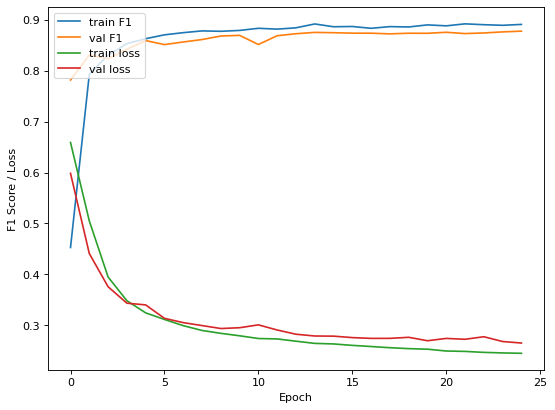

In [5]:
cnn.compile(optimizer=Adam(lr=1e-4), loss = 'binary_crossentropy', metrics=['accuracy', 'Recall', F1_score])
history_first_run = cnn.fit(X_train_all,y_train_all,epochs=25, validation_data=(X_val_all,y_val_all),batch_size=16)
# Plot the history 
history_graph_v(history_first_run, 'model_with_no_hp_tuning')

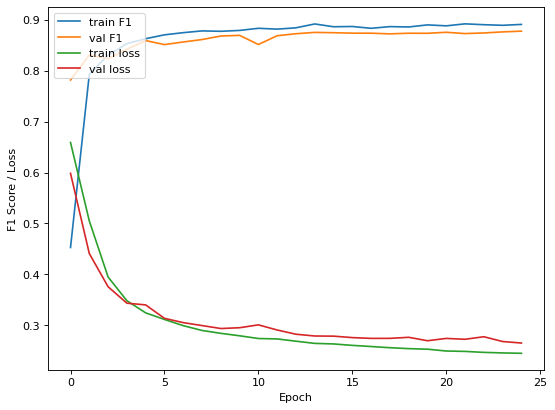

In [6]:
history_graph_v(history_first_run, 'model_with_no_hp_tuning')

In [7]:
# Get evaluation metrics & stats
print(classification_report(y_test_all,cnn.predict_classes(X_test_all)))
print(confusion_matrix(y_test_all,cnn.predict_classes(X_test_all)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       390
           1       0.90      0.87      0.89       390

    accuracy                           0.89       780
   macro avg       0.89      0.89      0.89       780
weighted avg       0.89      0.89      0.89       780

[[352  38]
 [ 49 341]]


Trial 18 Complete [00h 00m 27s]
val_F1_score: 0.8912778496742249

Best val_F1_score So Far: 0.9271969199180603
Total elapsed time: 00h 14m 04s
INFO:tensorflow:Oracle triggered exit
Epoch 1/25
220/220 [==============================] - 2s 7ms/step - loss: 0.4713 - accuracy: 0.7802 - F1_score: 0.7473 - val_loss: 0.3039 - val_accuracy: 0.8744 - val_F1_score: 0.8672
Epoch 2/25
220/220 [==============================] - 1s 6ms/step - loss: 0.3338 - accuracy: 0.8536 - F1_score: 0.8486 - val_loss: 0.2702 - val_accuracy: 0.8974 - val_F1_score: 0.8942
Epoch 3/25
220/220 [==============================] - 1s 6ms/step - loss: 0.2997 - accuracy: 0.8728 - F1_score: 0.8707 - val_loss: 0.2752 - val_accuracy: 0.8872 - val_F1_score: 0.8770
Epoch 4/25
220/220 [==============================] - 1s 6ms/step - loss: 0.2780 - accuracy: 0.8832 - F1_score: 0.8800 - val_loss: 0.2474 - val_accuracy: 0.9064 - val_F1_score: 0.9070
Epoch 5/25
220/220 [==============================] - 1s 6ms/step - loss: 0.2713 - 

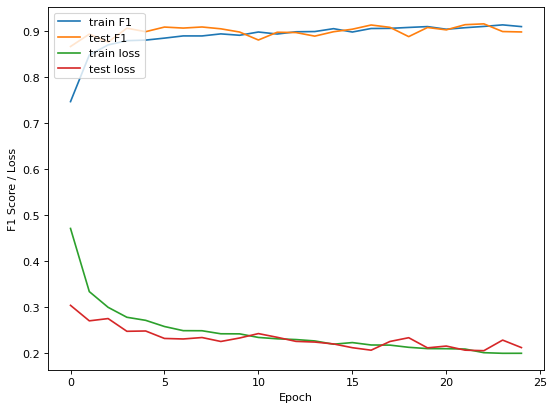

In [8]:
# Now perform the Hp Tuning 
hp_tuner = hp_search(X_train_all, X_val_all, y_train_all, y_val_all, 'HP_Tuning_all_CNN')
# get the HP from the best run 
best_params = best_model_params(hp_tuner)
# Evaluate on the test-set with a large amount of epochs to create graphic 
history = evaluate_model(best_params, X_train_all, X_val_all, X_test_all, y_train_all, y_val_all , y_test_all, 'model_cnn_only_all')
history_graph_t(history, 'model_with_hp_tuning')

In [5]:
best_params = model_parameter_getter('model_cnn_only_all_dict.json')

In [6]:
cnn_final = final_model_builder(best_params, (100,1))
cnn_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 96)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 96)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           61568     
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                204832    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [7]:
model = final_model_builder(best_params,(comp,1))
model.fit(X_train_en,y_train_en,epochs=10,batch_size=32,verbose=0)
print('en-en')
print(classification_report(y_test_en,model.predict_classes(X_test_en)))
print(confusion_matrix(y_test_en,model.predict_classes(X_test_en)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_es,y_train_es,epochs=10,batch_size=32,verbose=0)
print('es-es')
print(classification_report(y_test_es,model.predict_classes(X_test_es)))
print(confusion_matrix(y_test_es,model.predict_classes(X_test_es)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_it,y_train_it,epochs=10,batch_size=32, verbose=0)
print('it-it')
print(classification_report(y_test_it,model.predict_classes(X_test_it)))
print(confusion_matrix(y_test_it,model.predict_classes(X_test_it)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_fr,y_train_fr,epochs=10,batch_size=32,verbose=0)
print('fr-fr')
print(classification_report(y_test_fr,model.predict_classes(X_test_fr)))
print(confusion_matrix(y_test_fr,model.predict_classes(X_test_fr)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_hi,y_train_hi,epochs=10,batch_size=32,verbose=0)
print('hi-hi')
print(classification_report(y_test_hi,model.predict_classes(X_test_hi)))
print(confusion_matrix(y_test_hi,model.predict_classes(X_test_hi)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_pt,y_train_pt,epochs=10,batch_size=32,verbose=0)
print('pt-pt')
print(classification_report(y_test_pt,model.predict_classes(X_test_pt)))
print(confusion_matrix(y_test_pt,model.predict_classes(X_test_pt)))

en-en
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       660
           1       0.91      0.93      0.92       660

    accuracy                           0.92      1320
   macro avg       0.92      0.92      0.92      1320
weighted avg       0.92      0.92      0.92      1320

[[600  60]
 [ 45 615]]
es-es
              precision    recall  f1-score   support

           0       0.52      0.96      0.68        25
           1       0.95      0.49      0.65        43

    accuracy                           0.66        68
   macro avg       0.74      0.72      0.66        68
weighted avg       0.80      0.6

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fr-fr
              precision    recall  f1-score   support

           0       0.58      1.00      0.73        15
           1       1.00      0.35      0.52        17

    accuracy                           0.66        32
   macro avg       0.79      0.68      0.63        32
weighted avg       0.80      0.66      0.62        32

[[15  0]
 [11  6]]
hi-hi
              precision    recall  f1-score   support

           0       0.61      0.92      0.73        12
           1       0.92      0.61      0.73        18

    accuracy                           0.73        30
   macro avg       0.76      0.76      0.73        30
weighted avg       0.79      0.73      0.73        30

[[11  1]
 [ 7 11]]
pt-pt
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        51
           1       0.97      0.84      0.90        43

    accuracy                           0.91        94
   macro avg       0.93      0.91      0.91        94
weighted avg      

# Balancing Strategy: Up-sampling + original test sets 

In [11]:
# Load the data augmented with translated data from English, but with test sets only containing fake news from the 
# respective language

df = pd.read_csv('./Data/data_all_lang_balanced_no_test.csv')
df_es_test = pd.read_csv('./Data/es_test_origninal.csv')
df_it_test = pd.read_csv('./Data/it_test_origninal.csv')
df_hi_test = pd.read_csv('./Data/hi_test_origninal.csv')
df_pt_test = pd.read_csv('./Data/pt_test_origninal.csv')
df_fr_test = pd.read_csv('./Data/fr_test_origninal.csv')

df_en = df[df.lang_final=='en']
df_es = df[df.lang_final=='es']
df_it = df[df.lang_final=='it']
df_hi = df[df.lang_final=='hi']
df_pt = df[df.lang_final=='pt']
df_fr = df[df.lang_final=='fr']

# reset the indicies

df_en.reset_index(drop=True, inplace=True)
df_es.reset_index(drop=True, inplace=True)
df_it.reset_index(drop=True, inplace=True)
df_hi.reset_index(drop=True, inplace=True)
df_pt.reset_index(drop=True, inplace=True)
df_fr.reset_index(drop=True, inplace=True)

In [12]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(df_en['text_feat_clean'],df_en['target'], test_size=0.1, random_state=123)
X_train_es, X_test_es, y_train_es, y_test_es = df_es['text_feat_clean'], df_es_test['text_feat_clean'], df_es['target'], df_es_test['target']
X_train_it, X_test_it, y_train_it, y_test_it = df_it['text_feat_clean'], df_it_test['text_feat_clean'], df_it['target'], df_it_test['target']
X_train_hi, X_test_hi, y_train_hi, y_test_hi = df_hi['text_feat_clean'], df_hi_test['text_feat_clean'], df_hi['target'], df_hi_test['target']
X_train_fr, X_test_fr, y_train_fr, y_test_fr = df_fr['text_feat_clean'], df_fr_test['text_feat_clean'], df_fr['target'], df_fr_test['target']
X_train_pt, X_test_pt, y_train_pt, y_test_pt = df_pt['text_feat_clean'], df_pt_test['text_feat_clean'], df_pt['target'], df_pt_test['target']

In [13]:

stop_words_es = get_stop_words('es')
stop_words_it = get_stop_words('it')
stop_words_fr = get_stop_words('fr')
stop_words_pt = get_stop_words('pt')


# define the tf-idf vectorizers for the respective languages 

vectorizer_en = TfidfVectorizer(stop_words='english')
vectorizer_es = TfidfVectorizer(stop_words = stop_words_es )
vectorizer_it = TfidfVectorizer(stop_words = stop_words_it )
vectorizer_hi = TfidfVectorizer()
vectorizer_pt = TfidfVectorizer(stop_words = stop_words_pt)
vectorizer_fr = TfidfVectorizer(stop_words = stop_words_fr)


X_train_en = vectorizer_en.fit_transform(X_train_en)
X_test_en = vectorizer_en.transform(X_test_en)

X_train_es = vectorizer_es.fit_transform(X_train_es)
X_test_es = vectorizer_es.transform(X_test_es)

X_train_it = vectorizer_it.fit_transform(X_train_it)
X_test_it = vectorizer_it.transform(X_test_it)

X_train_hi = vectorizer_hi.fit_transform(X_train_hi)
X_test_hi = vectorizer_hi.transform(X_test_hi)

X_train_fr = vectorizer_fr.fit_transform(X_train_fr)
X_test_fr = vectorizer_fr.transform(X_test_fr)

X_train_pt = vectorizer_pt.fit_transform(X_train_pt)
X_test_pt = vectorizer_pt.transform(X_test_pt)

In [14]:
comp = min([100,min(list([X_train_en.shape[0],                       
                            X_train_es.shape[0],
                            X_train_it.shape[0],
                            X_train_fr.shape[0],
                            X_train_pt.shape[0],
                            X_train_hi.shape[0]]))])

print(comp)
svd_en = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_es = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_it = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_hi = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_pt = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_fr = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)

#svd_all = TruncatedSVD(n_components=comp, n_iter=7, random_state=42)

X_train_en = svd_en.fit_transform(X_train_en) 
X_test_en = svd_en.transform(X_test_en) 

X_train_es = svd_es.fit_transform(X_train_es)  
X_test_es = svd_es.transform(X_test_es) 

X_train_it = svd_it.fit_transform(X_train_it) 
X_test_it = svd_it.transform(X_test_it) 

X_train_hi = svd_hi.fit_transform(X_train_hi)  
X_test_hi = svd_hi.transform(X_test_hi) 

X_train_pt = svd_pt.fit_transform(X_train_pt)  
X_test_pt = svd_pt.transform(X_test_pt) 

X_train_fr = svd_fr.fit_transform(X_train_fr)  
X_test_fr = svd_fr.transform(X_test_fr) 

X_train_en, X_test_en = keras_vector(X_train_en), keras_vector(X_test_en)
X_train_es, X_test_es = keras_vector(X_train_es), keras_vector(X_test_es)
X_train_it, X_test_it = keras_vector(X_train_it), keras_vector(X_test_it)
X_train_hi, X_test_hi = keras_vector(X_train_hi), keras_vector(X_test_hi)
X_train_pt, X_test_pt = keras_vector(X_train_pt), keras_vector(X_test_pt)
X_train_fr, X_test_fr = keras_vector(X_train_fr), keras_vector(X_test_fr)

100


In [15]:
model = final_model_builder(best_params,(comp,1))
model.fit(X_train_en,y_train_en,epochs=10,batch_size=32,verbose=0)
print('en-en')
print(classification_report(y_test_en,model.predict_classes(X_test_en)))
print(confusion_matrix(y_test_en,model.predict_classes(X_test_en)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_es,y_train_es,epochs=10,batch_size=32,verbose=0)
print('es-es')
print(classification_report(y_test_es,model.predict_classes(X_test_es)))
print(confusion_matrix(y_test_es,model.predict_classes(X_test_es)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_it,y_train_it,epochs=10,batch_size=32, verbose=0)
print('it-it')
print(classification_report(y_test_it,model.predict_classes(X_test_it)))
print(confusion_matrix(y_test_it,model.predict_classes(X_test_it)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_fr,y_train_fr,epochs=10,batch_size=32,verbose=0)
print('fr-fr')
print(classification_report(y_test_fr,model.predict_classes(X_test_fr)))
print(confusion_matrix(y_test_fr,model.predict_classes(X_test_fr)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_hi,y_train_hi,epochs=10,batch_size=32,verbose=0)
print('hi-hi')
print(classification_report(y_test_hi,model.predict_classes(X_test_hi)))
print(confusion_matrix(y_test_hi,model.predict_classes(X_test_hi)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_pt,y_train_pt,epochs=10,batch_size=32,verbose=0)
print('pt-pt')
print(classification_report(y_test_pt,model.predict_classes(X_test_pt)))
print(confusion_matrix(y_test_pt,model.predict_classes(X_test_pt)))

en-en
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       183
           1       0.95      0.83      0.89       197

    accuracy                           0.89       380
   macro avg       0.90      0.89      0.89       380
weighted avg       0.90      0.89      0.89       380

[[175   8]
 [ 33 164]]
es-es
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        40
           1       0.94      0.82      0.88        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80

[[38  2]
 [ 7 33]]
it-it
              precision    recall  f1-score   support

           0       0.68      0.95      0.79        40
           1       0.92      0.55      0.69        40

    accuracy                           0.75        80
   macro avg       0.80      0.75      0.74        80
weighted avg  

# Balancing Strategy: No balancing

In [16]:
# Load and perform the pre-proccessing pipe for the unbalanced data

# get the configs for the Azure Workspace
ws = Workspace.from_config()
# initialize location of the data (blob)
datastore_name = 'mlthesisdatablob'
dataset_name='data.cleaned.raw'
#load the data of english examples
datastore = Datastore.get(ws, datastore_name)
datapath = datastore.path('data_all_lang.csv')
dataset = Dataset.auto_read_files(datapath)

d = dataset.register(workspace=ws, name=dataset_name, exist_ok=True, update_if_exist=True)

dataset = Dataset.get(ws,dataset_name)
# create a dataframe
df = dataset.to_pandas_dataframe()

#Alternatively: Load data from csv in directory 
# import pandas as pd

# df_en = pd.read_csv('data_english.csv')

df.head()

# create a dataset for each language

df_en = df[df.lang_final=='en']
df_es = df[df.lang_final=='es']
df_it = df[df.lang_final=='it']
df_hi = df[df.lang_final=='hi']
df_pt = df[df.lang_final=='pt']
df_fr = df[df.lang_final=='fr']

# reset the indicies

df_en.reset_index(drop=True, inplace=True)
df_es.reset_index(drop=True, inplace=True)
df_it.reset_index(drop=True, inplace=True)
df_hi.reset_index(drop=True, inplace=True)
df_pt.reset_index(drop=True, inplace=True)
df_fr.reset_index(drop=True, inplace=True)

X_en, y_en = df_en['text_feat_clean'], df_en['target']
X_es, y_es = df_es['text_feat_clean'], df_es['target']
X_it, y_it = df_it['text_feat_clean'], df_it['target']
X_hi, y_hi = df_hi['text_feat_clean'], df_hi['target']
X_fr, y_fr = df_fr['text_feat_clean'], df_fr['target']
X_pt, y_pt = df_pt['text_feat_clean'], df_pt['target']

X_all, y_all = df['text_feat_clean'], df['target']


X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(X_en, y_en,test_size=0.2,random_state=125, 
                                                                stratify=y_en)
X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(X_es, y_es,test_size=0.2,random_state=125, 
                                                                stratify=y_es)
X_train_it, X_test_it, y_train_it, y_test_it = train_test_split(X_it, y_it,test_size=0.2,random_state=125, 
                                                                stratify=y_it)
X_train_hi, X_test_hi, y_train_hi, y_test_hi = train_test_split(X_hi, y_hi,test_size=0.2,random_state=125, 
                                                                stratify=y_hi)
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(X_pt, y_pt,test_size=0.2,random_state=125, 
                                                                stratify=y_pt)
X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(X_fr, y_fr,test_size=0.2,random_state=125, 
                                                                stratify=y_fr)
                                                                                       
                                                                                    
                                                                                       

X_train_all, X_val_all, X_test_all, y_train_all, y_val_all, y_test_all = train_val_test_split(X_all, y_all,
                                                                                       test_size=0.1,
                                                                                        val_size=0.2,
                                                                                       random_state=125)

stop_words_es = get_stop_words('es')
stop_words_it = get_stop_words('it')
stop_words_fr = get_stop_words('fr')
stop_words_pt = get_stop_words('pt')


# define the tf-idf vectorizers for the respective languages 

vectorizer_en = TfidfVectorizer(stop_words='english')
vectorizer_es = TfidfVectorizer(stop_words = stop_words_es)
vectorizer_it = TfidfVectorizer(stop_words = stop_words_it)
vectorizer_hi = TfidfVectorizer()
vectorizer_pt = TfidfVectorizer(stop_words = stop_words_pt)
vectorizer_fr = TfidfVectorizer(stop_words = stop_words_fr)

vectorizer_all = TfidfVectorizer()

X_train_en = vectorizer_en.fit_transform(X_train_en)
X_test_en = vectorizer_en.transform(X_test_en)

X_train_es = vectorizer_es.fit_transform(X_train_es)
X_test_es = vectorizer_es.transform(X_test_es)

X_train_it = vectorizer_it.fit_transform(X_train_it)
X_test_it = vectorizer_it.transform(X_test_it)

X_train_hi = vectorizer_hi.fit_transform(X_train_hi)
X_test_hi = vectorizer_hi.transform(X_test_hi)

X_train_fr = vectorizer_fr.fit_transform(X_train_fr)
X_test_fr = vectorizer_fr.transform(X_test_fr)

X_train_pt = vectorizer_pt.fit_transform(X_train_pt)
X_test_pt = vectorizer_pt.transform(X_test_pt)

X_train_all = vectorizer_pt.fit_transform(X_train_all)
X_val_all = vectorizer_pt.transform(X_val_all)
X_test_all = vectorizer_pt.transform(X_test_all)

comp = min([100,min(list([X_train_en.shape[0], 
                         
                         X_train_es.shape[0],
                         X_train_it.shape[0],
                         X_train_fr.shape[0],
                         X_train_pt.shape[0],
                         X_train_hi.shape[0]]))])

print(comp)

svd_en = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_es = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_it = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_hi = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_pt = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)
svd_fr = TruncatedSVD(n_components=comp, n_iter=5, random_state=123)



X_train_en = svd_en.fit_transform(X_train_en) 
X_test_en = svd_en.transform(X_test_en) 

X_train_es = svd_es.fit_transform(X_train_es)  
X_test_es = svd_es.transform(X_test_es) 

X_train_it = svd_it.fit_transform(X_train_it) 
X_test_it = svd_it.transform(X_test_it) 

X_train_hi = svd_hi.fit_transform(X_train_hi)  
X_test_hi = svd_hi.transform(X_test_hi) 

X_train_pt = svd_pt.fit_transform(X_train_pt)  
X_test_pt = svd_pt.transform(X_test_pt) 

X_train_fr = svd_fr.fit_transform(X_train_fr)  
X_test_fr = svd_fr.transform(X_test_fr) 

X_train_all = svd_all.fit_transform(X_train_all) 
X_val_all = svd_all.transform(X_val_all) 
X_test_all = svd_all.transform(X_test_all)

X_train_en, X_test_en = keras_vector(X_train_en), keras_vector(X_test_en)
X_train_es, X_test_es = keras_vector(X_train_es), keras_vector(X_test_es)
X_train_it, X_test_it = keras_vector(X_train_it), keras_vector(X_test_it)
X_train_hi, X_test_hi = keras_vector(X_train_hi), keras_vector(X_test_hi)
X_train_pt, X_test_pt = keras_vector(X_train_pt), keras_vector(X_test_pt)
X_train_fr, X_test_fr = keras_vector(X_train_fr), keras_vector(X_test_fr)



100


In [17]:
# Models trained with the unbalanced data

model = final_model_builder(best_params,(comp,1))
model.fit(X_train_en,y_train_en,epochs=10,batch_size=32,verbose=0)
print('en-en')
print(classification_report(y_test_en,model.predict_classes(X_test_en)))
print(confusion_matrix(y_test_en,model.predict_classes(X_test_en)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_es,y_train_es,epochs=10,batch_size=32,verbose=0)
print('es-es')
print(classification_report(y_test_es,model.predict_classes(X_test_es)))
print(confusion_matrix(y_test_es,model.predict_classes(X_test_es)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_it,y_train_it,epochs=10,batch_size=32, verbose=0)
print('it-it')
print(classification_report(y_test_it,model.predict_classes(X_test_it)))
print(confusion_matrix(y_test_it,model.predict_classes(X_test_it)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_fr,y_train_fr,epochs=10,batch_size=32,verbose=0)
print('fr-fr')
print(classification_report(y_test_fr,model.predict_classes(X_test_fr)))
print(confusion_matrix(y_test_fr,model.predict_classes(X_test_fr)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_hi,y_train_hi,epochs=10,batch_size=32,verbose=0)
print('hi-hi')
print(classification_report(y_test_hi,model.predict_classes(X_test_hi)))
print(confusion_matrix(y_test_hi,model.predict_classes(X_test_hi)))


model = final_model_builder(best_params,(comp,1))
model.fit(X_train_pt,y_train_pt,epochs=10,batch_size=32,verbose=0)
print('pt-pt')
print(classification_report(y_test_pt,model.predict_classes(X_test_pt)))
print(confusion_matrix(y_test_pt,model.predict_classes(X_test_pt)))

en-en
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       923
           1       0.94      0.88      0.91       660

    accuracy                           0.93      1583
   macro avg       0.93      0.92      0.93      1583
weighted avg       0.93      0.93      0.93      1583

[[886  37]
 [ 77 583]]
es-es
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       258
           1       0.78      0.82      0.80        34

    accuracy                           0.95       292
   macro avg       0.88      0.90      0.89       292
weighted avg       0.95      0.95      0.95       292

[[250   8]
 [  6  28]]
it-it
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       216
           1       0.50      0.12      0.20         8

    accuracy                           0.96       224
   macro avg       0.73      0.56      0.59       224
weighted a